# Download dataset

In [ ]:
# # import kagglehub

# # Download latest version
# path = kagglehub.dataset_download("jainaru/parkinson-disease-detection")

# print("Path to dataset files:", path)

In [ ]:
# import kagglehub

# # Download latest version
# path = kagglehub.dataset_download("mozillaorg/common-voice")

# print("Path to dataset files:", path)

In [ ]:
# # This Python 3 environment comes with many helpful analytics libraries installed
# # It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# # For example, here's several helpful packages to load

# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# # Input data files are available in the read-only "../input/" directory
# # For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# path='/kaggle/input/parkinson-patient/Parkinson-Patient-Speech-Dataset-master/denoised-speech-dataset'
# for dirname, _, filenames in os.walk(path):
#     for filename in filenames:
#         # print(filename)
#         print(os.path.join(dirname, filename))

# # You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# # You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Preprocessing data

## Visualize data

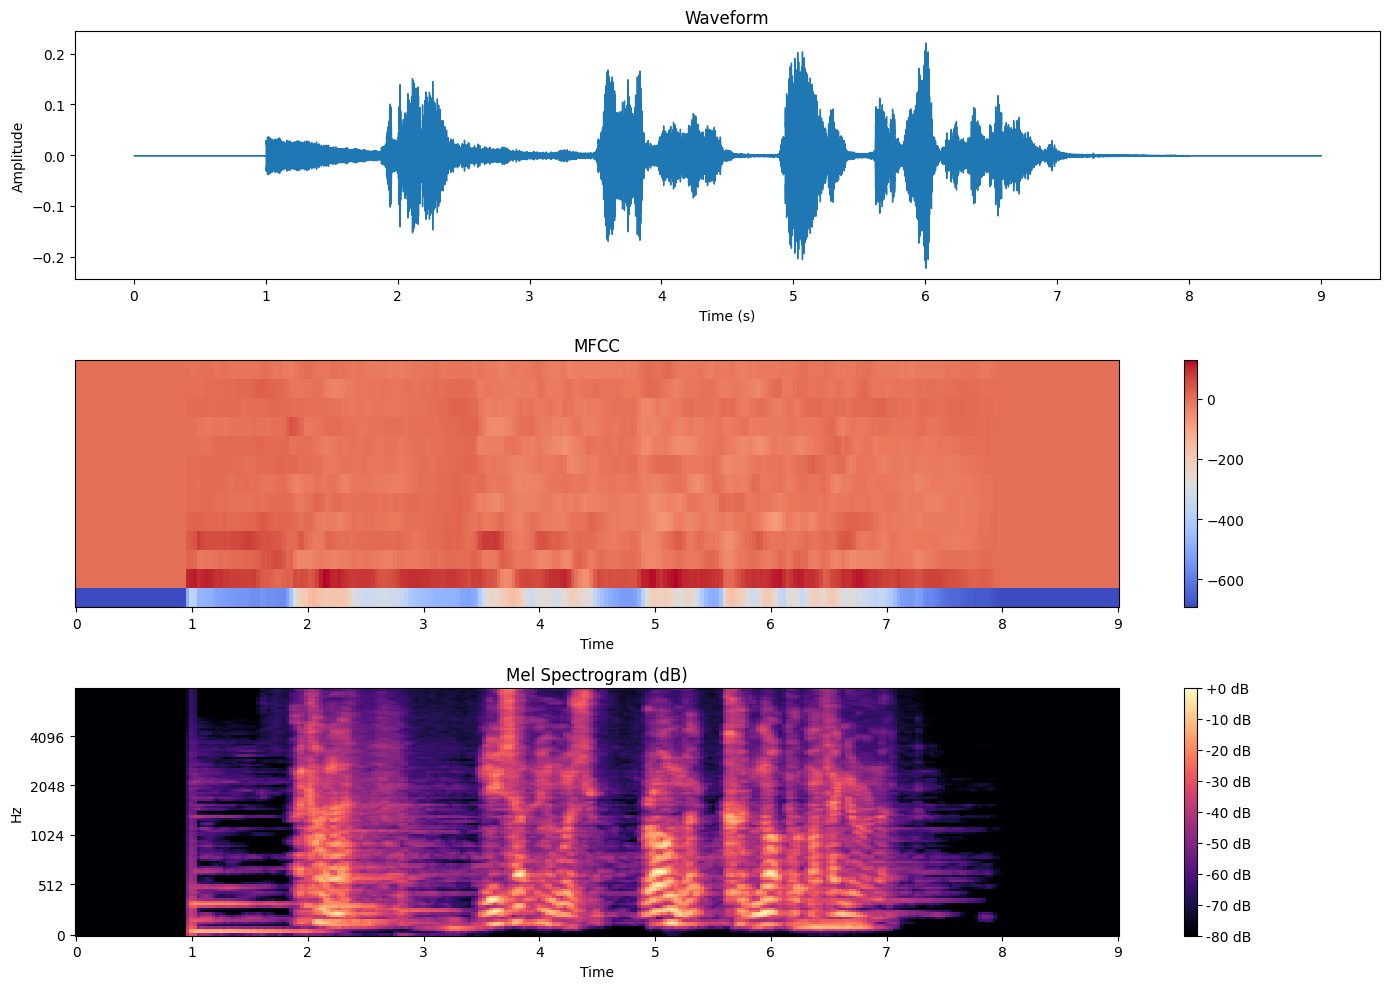

In [1]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np

# Replace with the path to your .wav file
file_path = '/kaggle/input/parkinson-patient/Parkinson-Patient-Speech-Dataset-master/denoised-speech-dataset/DL/DL1.wav'  # e.g., 'healthy_01.wav' or 'parkinson_01.wav'

# Load audio
y, sr = librosa.load(file_path, sr=None)

# Compute features
mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=2048, hop_length=512, n_mels=128)
mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)

# Plot
plt.figure(figsize=(14, 10))

# 1. Waveform
plt.subplot(3, 1, 1)
librosa.display.waveshow(y, sr=sr)
plt.title('Waveform')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')

# 2. MFCC
plt.subplot(3, 1, 2)
librosa.display.specshow(mfcc, x_axis='time', sr=sr)
plt.colorbar()
plt.title('MFCC')

# 3. Mel Spectrogram
plt.subplot(3, 1, 3)
librosa.display.specshow(mel_spec_db, sr=sr, x_axis='time', y_axis='mel')
plt.colorbar(format='%+2.0f dB')
plt.title('Mel Spectrogram (dB)')

plt.tight_layout()
plt.show()


(171648,)
(13, 336)
(128, 336)


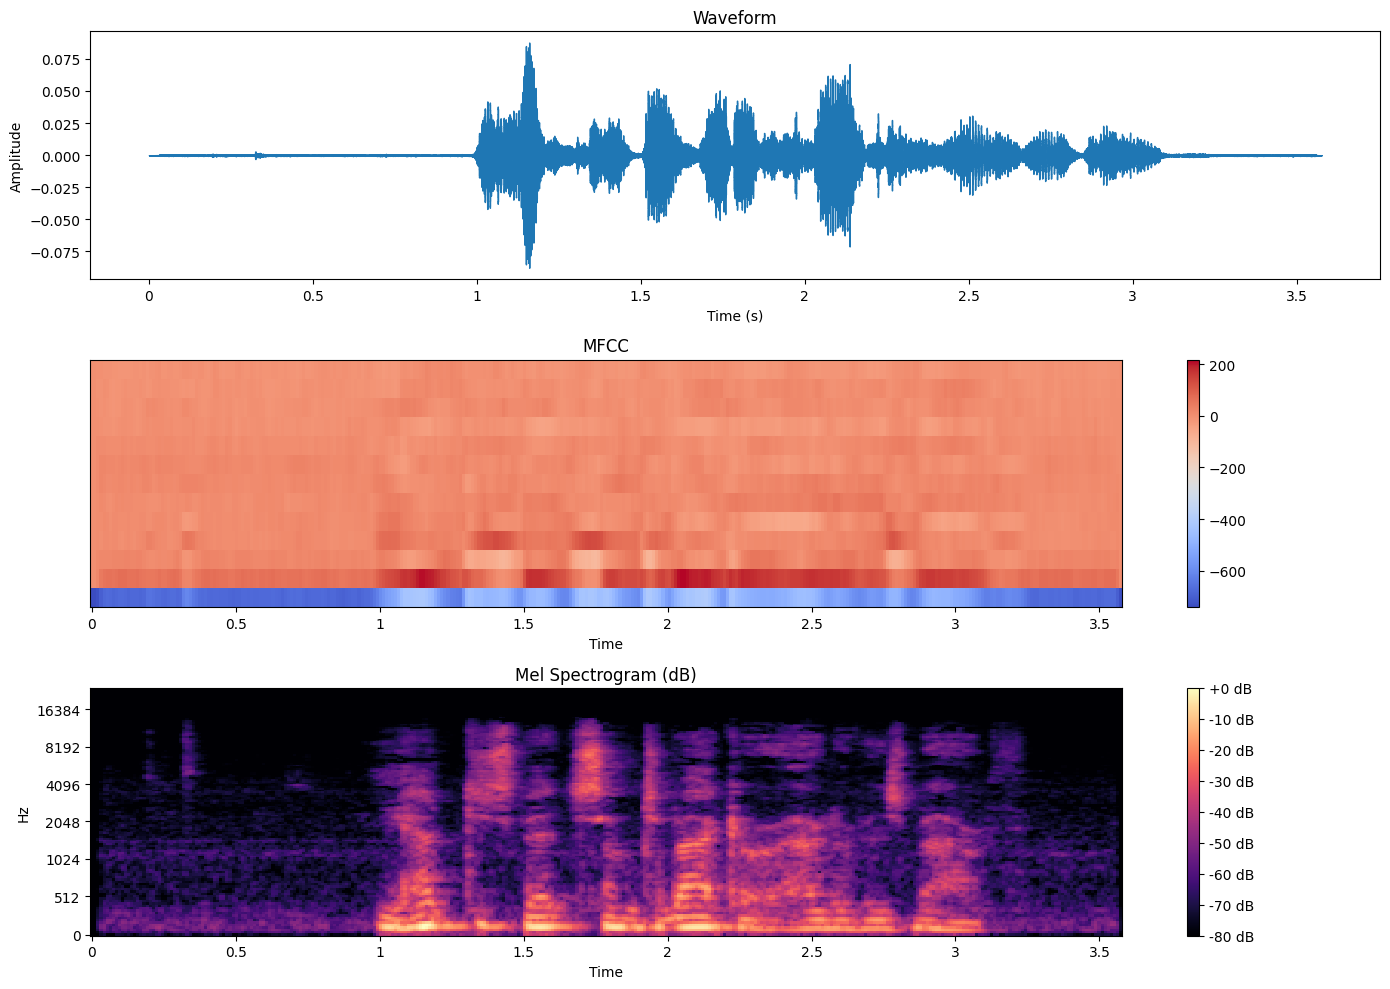

In [6]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np

# Replace with the path to your .wav file
file_path = '/kaggle/input/common-voice/cv-other-train/cv-other-train/sample-000000.mp3'  # e.g., 'healthy_01.wav' or 'parkinson_01.wav'

# Load audio
y, sr = librosa.load(file_path, sr=None)

# Compute features
mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=2048, hop_length=512, n_mels=128)
mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)

# Plot
plt.figure(figsize=(14, 10))

# 1. Waveform
plt.subplot(3, 1, 1)
librosa.display.waveshow(y, sr=sr)
print(y.shape)
plt.title('Waveform')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')

# 2. MFCC
plt.subplot(3, 1, 2)
librosa.display.specshow(mfcc, x_axis='time', sr=sr)
print(mfcc.shape)
plt.colorbar()
plt.title('MFCC')

# 3. Mel Spectrogram
plt.subplot(3, 1, 3)
librosa.display.specshow(mel_spec_db, sr=sr, x_axis='time', y_axis='mel')
print(mel_spec_db.shape)
plt.colorbar(format='%+2.0f dB')
plt.title('Mel Spectrogram (dB)')

plt.tight_layout()
plt.show()


## Load data

In [1]:
import os
import librosa
import numpy as np
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

# Parameters
SR = 16000
N_MFCC = 50

def extract_audio_features(wav_path):
    y, sr = librosa.load(wav_path, sr=SR)
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=N_MFCC)
    return np.mean(mfcc, axis=1)  # shape: (N_MFCC,)

def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^a-z\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

# Collect data with person information
data = []
person_data = {}  # Dictionary to store data per person
root_dir = '/kaggle/input/parkinson-patient/Parkinson-Patient-Speech-Dataset-master/denoised-speech-dataset'

print("Loading Parkinson's data...")
for folder in os.listdir(root_dir):
    folder_path = os.path.join(root_dir, folder)
    print(f"Processing folder: {folder}")
    if not os.path.isdir(folder_path):
        continue
    
    # Initialize person data if not exists
    if folder not in person_data:
        person_data[folder] = []
    
    # Recursively walk through folder_path and its subfolders
    for subdir, _, files in os.walk(folder_path):
        for file in files:
            if file.endswith('.wav'):
                wav_path = os.path.join(subdir, file)
                txt_path = os.path.splitext(wav_path)[0] + '.txt'
                if os.path.exists(txt_path):
                    try:
                        # Audio features
                        audio_feat = extract_audio_features(wav_path)
                       
                        # Text features
                        with open(txt_path, 'r', encoding='utf-8') as f:
                            raw_text = f.read()
                        clean_text = preprocess_text(raw_text)
                
                        # Store with person information (0 = Parkinson's)
                        sample = (audio_feat, clean_text, 0, folder)
                        data.append(sample)
                        person_data[folder].append(sample)
                    except Exception as e:
                        print(f"Error processing {wav_path}: {e}")
                        continue

print(f"Total Parkinson's samples: {len(data)}")
print(f"Number of Parkinson's people: {len(person_data)}")

# Create separate lists for features and labels
audio_features = [item[0] for item in data]
texts = [item[1] for item in data]
y_0 = [item[2] for item in data]
person_ids = [item[3] for item in data]

# Vectorize text for Parkinson's data
vectorizer = TfidfVectorizer(max_features=100)
X_text_0 = vectorizer.fit_transform(texts).toarray()

# Stack audio and text features
X_audio_0 = np.stack(audio_features)
X_0 = np.concatenate([X_audio_0, X_text_0], axis=1)

print("Parkinson's feature shape:", X_0.shape)
print("Person distribution:")
for person, samples in person_data.items():
    print(f"Person {person}: {len(samples)} samples")

Loading Parkinson's data...
Processing folder: emma
Processing folder: Faces
Processing folder: Tessi
Processing folder: DL
Processing folder: LW
Total Parkinson's samples: 578
Number of Parkinson's people: 5
Parkinson's feature shape: (578, 150)
Person distribution:
Person emma: 361 samples
Person Faces: 113 samples
Person Tessi: 36 samples
Person DL: 48 samples
Person LW: 20 samples


In [15]:
import os
import pandas as pd

# Load healthy data (Common Voice dataset)
audio_folder = '/kaggle/input/common-voice/cv-other-train/cv-other-train'
csv_path = '/kaggle/input/common-voice/cv-other-train.csv'
N = X_0.shape[0]  # Match the number of Parkinson's samples

def extract_audio_features_healthy(file_path):
    y, sr = librosa.load(file_path, sr=SR)
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=N_MFCC)
    return np.mean(mfcc, axis=1)

print("Loading healthy data...")
df = pd.read_csv(csv_path)
print("CSV loaded:", df.shape)

audio_features_healthy = []
texts_healthy = []
person_ids_healthy = []
used = 0

for idx, row in df.iterrows():
    if used >= N:
        break
        
    rel_path = row['filename']
    text = row['text']
    audio_path = os.path.join(audio_folder, os.path.basename(rel_path))
    
    if os.path.exists(audio_path):
        try:
            audio_feat = extract_audio_features_healthy(audio_path)
            text_clean = preprocess_text(text)
            
            audio_features_healthy.append(audio_feat)
            texts_healthy.append(text_clean)
            
            # Create unique person ID for each healthy sample
            person_id = f"healthy_{os.path.basename(rel_path).split('.')[0]}"
            person_ids_healthy.append(person_id)
            used += 1
        except Exception as e:
            print(f"Error processing {audio_path}: {e}")
            continue

print(f"Total healthy samples: {len(audio_features_healthy)}")

# Vectorize text for healthy data using the same vectorizer
X_text_1 = vectorizer.transform(texts_healthy).toarray()

# Stack audio and text features
X_audio_1 = np.stack(audio_features_healthy)
X_1 = np.concatenate([X_audio_1, X_text_1], axis=1)
y_1 = np.ones(X_1.shape[0])  # 1 = Healthy

print("Healthy feature shape:", X_1.shape)

Loading healthy data...
CSV loaded: (145135, 8)
Total healthy samples: 578
Healthy feature shape: (578, 150)


In [ ]:
# Combine both datasets
Input = np.concatenate([X_0, X_1])
Output = np.concatenate([y_0, y_1])
All_person_ids = person_ids + person_ids_healthy

print("Combined dataset:")
print(f"Input shape: {Input.shape}")
print(f"Output shape: {Output.shape}")

# Create person-to-indices mapping
person_to_indices = {}
for idx, person_id in enumerate(All_person_ids):
    if person_id not in person_to_indices:
        person_to_indices[person_id] = []
    person_to_indices[person_id].append(idx)



Combined dataset:
Input shape: (1156, 150)
Output shape: (1156,)


In [36]:
from sklearn.model_selection import train_test_split
import numpy as np

# Person-based splitting with specific assignment
print("Performing person-based data splitting...")


# Get unique people and their labels
unique_people = list(set(All_person_ids))
people_labels = []
for person_id in unique_people:
    # Get the first sample's label for this person (all samples from same person have same label)
    first_idx = person_to_indices[person_id][0]
    people_labels.append(Output[first_idx])

people_labels = np.array(people_labels)

# Get all Parkinson's people (label == 0) and healthy people (label == 1)
parkinson_people = [person_id for person_id in unique_people if Output[person_to_indices[person_id][0]] == 0]
healthy_people = [person_id for person_id in unique_people if Output[person_to_indices[person_id][0]] == 1]


# Assign specific Parkinson's person to validation
if len(parkinson_people) >= 3:  # Make sure we have enough people
    parkinson_valid = parkinson_people[2]  # Index 2 for validation
    parkinson_train_test = [p for p in parkinson_people if p != parkinson_valid]
    
   
else:
    print("Error: Not enough Parkinson's people for specific assignment")
    # Fallback to original logic
    parkinson_valid = parkinson_people[0] if len(parkinson_people) > 0 else None
    parkinson_train_test = [p for p in parkinson_people if p != parkinson_valid]

# Split remaining Parkinson's people into train and test
if len(parkinson_train_test) > 1:
    parkinson_train, parkinson_test = train_test_split(
        parkinson_train_test, test_size=0.25, random_state=42  # 25% for test
    )
else:
    parkinson_train = parkinson_train_test
    parkinson_test = []

# For healthy people, split into train/validation/test
healthy_trainval, healthy_test = train_test_split(
    healthy_people, test_size=0.2, random_state=42  # 20% for test
)

if len(healthy_trainval) > 1:
    healthy_train, healthy_valid = train_test_split(
        healthy_trainval, test_size=0.2, random_state=42  # 20% of remaining for validation
    )
else:
    healthy_train = healthy_trainval
    healthy_valid = []

# Convert single items to lists if needed
if isinstance(parkinson_test, str):
    parkinson_test = [parkinson_test]
if isinstance(healthy_test, str):
    healthy_test = [healthy_test]
if isinstance(healthy_valid, str):
    healthy_valid = [healthy_valid]

# Combine assignments
people_train = parkinson_train + healthy_train
people_valid = [parkinson_valid] + healthy_valid
people_test = parkinson_test + healthy_test

# Remove None values
people_train = [p for p in people_train if p is not None]
people_valid = [p for p in people_valid if p is not None]
people_test = [p for p in people_test if p is not None]



# Count labels for each split
train_parkinson = sum(1 for p in people_train if Output[person_to_indices[p][0]] == 0)
train_healthy = sum(1 for p in people_train if Output[person_to_indices[p][0]] == 1)
valid_parkinson = sum(1 for p in people_valid if Output[person_to_indices[p][0]] == 0)
valid_healthy = sum(1 for p in people_valid if Output[person_to_indices[p][0]] == 1)
test_parkinson = sum(1 for p in people_test if Output[person_to_indices[p][0]] == 0)
test_healthy = sum(1 for p in people_test if Output[person_to_indices[p][0]] == 1)

print(f"\nSplit results:")
print(f"Train people: {len(people_train)} (Parkinson: {train_parkinson}, Healthy: {train_healthy})")
print(f"Valid people: {len(people_valid)} (Parkinson: {valid_parkinson}, Healthy: {valid_healthy})")
print(f"Test people: {len(people_test)} (Parkinson: {test_parkinson}, Healthy: {test_healthy})")

# Create sample indices for each split
train_indices = []
valid_indices = []
test_indices = []

for person_id in people_train:
    train_indices.extend(person_to_indices[person_id])

for person_id in people_valid:
    valid_indices.extend(person_to_indices[person_id])

for person_id in people_test:
    test_indices.extend(person_to_indices[person_id])

# Convert to numpy arrays and sort for consistent ordering
train_indices = np.sort(np.array(train_indices))
valid_indices = np.sort(np.array(valid_indices))
test_indices = np.sort(np.array(test_indices))

# Create the actual splits
X_train = Input[train_indices]
y_train = Output[train_indices]
X_valid = Input[valid_indices]
y_valid = Output[valid_indices]
X_test = Input[test_indices]
y_test = Output[test_indices]

print(f"\nFinal sample splits:")
print(f"Train: {X_train.shape[0]} samples ({X_train.shape[0]/Input.shape[0]*100:.1f}%)")
print(f"Valid: {X_valid.shape[0]} samples ({X_valid.shape[0]/Input.shape[0]*100:.1f}%)")
print(f"Test: {X_test.shape[0]} samples ({X_test.shape[0]/Input.shape[0]*100:.1f}%)")

# DATA NORMALIZATION

# Normalize audio features (first 50 columns) using training data statistics
min_x_audio = np.min(X_train[:,:50])
max_x_audio = np.max(X_train[:,:50])

print(f"\nAudio features normalization parameters:")
print(f"Min value: {min_x_audio:.4f}")
print(f"Max value: {max_x_audio:.4f}")

# Apply min-max normalization to audio features for all splits
X_train[:,:50] = (X_train[:,:50] - min_x_audio) / (max_x_audio - min_x_audio)
X_valid[:,:50] = (X_valid[:,:50] - min_x_audio) / (max_x_audio - min_x_audio)
X_test[:,:50] = (X_test[:,:50] - min_x_audio) / (max_x_audio - min_x_audio)

print(f"\nNormalized data ranges:")
print(f"Train audio features: [{np.min(X_train[:,:50]):.4f}, {np.max(X_train[:,:50]):.4f}]")
print(f"Valid audio features: [{np.min(X_valid[:,:50]):.4f}, {np.max(X_valid[:,:50]):.4f}]")
print(f"Test audio features: [{np.min(X_test[:,:50]):.4f}, {np.max(X_test[:,:50]):.4f}]")




Performing person-based data splitting...

Split results:
Train people: 372 (Parkinson: 3, Healthy: 369)
Valid people: 94 (Parkinson: 1, Healthy: 93)
Test people: 117 (Parkinson: 1, Healthy: 116)

Final sample splits:
Train: 891 samples (77.1%)
Valid: 113 samples (9.8%)
Test: 152 samples (13.1%)

Audio features normalization parameters:
Min value: -1131.3710
Max value: 163.0855

Normalized data ranges:
Train audio features: [0.0000, 1.0000]
Valid audio features: [0.0000, 0.9881]
Test audio features: [0.0000, 0.9916]


Unique classes in Output: [0. 1.]
Number of classes: 2
[578 578]


Text(0.5, 1.0, 'The distribution of different classes')

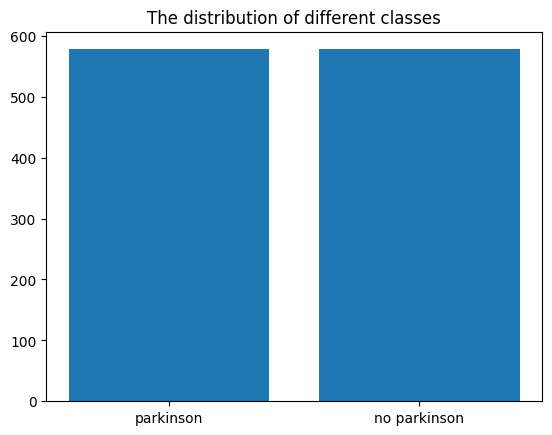

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Number of unique classes in Output/y
unique_classes = np.unique(Output)
num_classes = len(unique_classes)

print(f"Unique classes in Output: {unique_classes}")
print(f"Number of classes: {num_classes}")

# Class distribution
unique, counts = np.unique(Output, return_counts=True)
print(counts)
LABELS=["parkinson","no parkinson"]
plt.bar(LABELS, counts)
plt.title("The distribution of different classes")

Text(0.5, 1.0, 'Number of sample in three dataset')

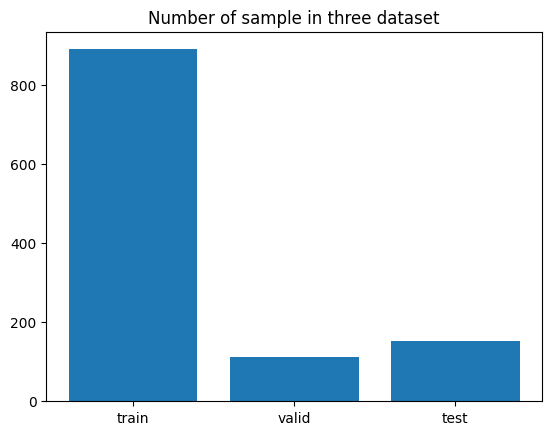

In [38]:
import matplotlib.pyplot as plt
LABELS=["train","valid","test"]
plt.bar(LABELS, np.array([X_train.shape[0],X_valid.shape[0],X_test.shape[0]]))
plt.title("Number of sample in three dataset")

In [39]:
def get_callbacks(checkpoint_filepath,patience = 5):
    reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                                     factor=0.1,
                                                     patience=patience,
                                                     min_lr=1e-20,
                                                     verbose=1)
    checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath,
                                                    save_weights_only=False,
                                                    monitor='val_accuracy',
                                                    mode='max',
                                                    save_best_only=True,
                                                    verbose=1)
    # stop=tf.keras.callbacks.EarlyStopping(monitor='loss', patience=patience*3)
    # return [reduce_lr,stop]
    return [reduce_lr, checkpoint]

In [40]:
from sklearn.metrics import f1_score
import pandas as pd
from sklearn.metrics import confusion_matrix
import seaborn as sns
classes = ['parkinson', 'no parkinson']
def plot_confusion_matrix(true_label, predict_label, pl = True):
    true_label = true_label.reshape(true_label.shape[0], 1)
    predict_label = predict_label.reshape(predict_label.shape[0], 1)

    cm = confusion_matrix(y_true = true_label, y_pred = predict_label)
    print(cm)
    cm_per = np.round(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]*100,2)

    if pl == True:
        df_cm = pd.DataFrame(cm_per, index = classes, columns = classes)
        plt.figure(figsize = (7, 6))
        sns.heatmap(df_cm, annot=True, cmap = "Blues",vmax=100, linewidths=.1 ,fmt='.2f')
        plt.title("Confusion matrix")
        plt.xlabel('Predict', fontsize=12)
        plt.ylabel('True', fontsize=12)
        plt.tight_layout()

# CNN

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
import time

# Reshape input for Conv1D: (samples, steps, channels)
# Here, steps=150, channels=1
X_train_cnn = X_train[:,:50].reshape(-1, X_train[:,:50].shape[1], 1)
X_valid_cnn = X_valid[:,:50].reshape(-1, X_valid[:,:50].shape[1], 1)
X_test_cnn  = X_test[:,:50].reshape(-1, X_test[:,:50].shape[1], 1)
print(X_train_cnn.shape)#(739, 50, 1)
num_classes = len(set(y_train))

model1 = models.Sequential([
    tf.keras.Input(shape=(X_train_cnn.shape[1], X_train_cnn.shape[2])),
    layers.Conv1D(32, kernel_size=3, activation='relu'),
    layers.MaxPooling1D(pool_size=2),
    layers.Conv1D(64, kernel_size=3, activation='relu'),
    layers.MaxPooling1D(pool_size=2),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(num_classes, activation='softmax')
])


model1.summary()
checkpoint_filepath = 'cnn_'+str(time.time())+'.keras'

callbacks = get_callbacks(checkpoint_filepath,5)
optimizer = tf.keras.optimizers.RMSprop(learning_rate=1e-3)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)
metrics = ['accuracy']
model1.compile(optimizer, loss=loss, metrics=metrics)

# Train
history = model1.fit(
    X_train_cnn, y_train,
    validation_data=(X_valid_cnn, y_valid),
    epochs=400,
    callbacks = callbacks,
    batch_size=16
)



In [ ]:
# model1 = tf.keras.models.load_model('/kaggle/working/cnn_1750044528.2824473.keras')

In [ ]:
import matplotlib.pyplot as plt
plt.subplot(121)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.subplot(122)
plt.plot(history.history['accuracy'], label='Training Accuracy')    
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.show()

In [ ]:
import numpy as np
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, classification_report,
    roc_curve, auc, precision_recall_curve, average_precision_score, confusion_matrix, ConfusionMatrixDisplay,
    RocCurveDisplay, PrecisionRecallDisplay
)
import matplotlib.pyplot as plt

# Replace with your actual labels and predictions
y_true = y_test  # true labels
model=model1
y_prob = model.predict(X_test_cnn)  # predicted probabilities from CNN

# If binary classification (e.g., 0 or 1)
binary_classification = y_prob.shape[1] == 1
if binary_classification:
    y_pred = (y_prob > 0.5).astype(int).flatten()
else:
    y_pred = np.argmax(y_prob, axis=1)

# Metrics
acc = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

print(f"\nCNN Model Metrics:")
print(f"Accuracy: {acc:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1:.2f}")
print("\nClassification Report:\n", classification_report(y_true, y_pred))

# Confusion Matrix
ConfusionMatrixDisplay.from_predictions(y_true, y_pred, cmap='Blues')
plt.title("Confusion Matrix")
plt.grid(False)
plt.show()

# ROC and Precision-Recall Curves
n_classes = len(np.unique(y_true))
y_score = y_prob  # already predicted probs

fpr, tpr, roc_auc = dict(), dict(), dict()
pr_precision, pr_recall, average_precision = dict(), dict(), dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true == i, y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

    pr_precision[i], pr_recall[i], _ = precision_recall_curve(y_true == i, y_score[:, i])
    average_precision[i] = average_precision_score(y_true == i, y_score[:, i])

# Plot ROC Curves
plt.figure(figsize=(8, 8))
colors = ['blue', 'green', 'red', 'orange', 'purple', 'black']
for i, color in enumerate(colors[:n_classes]):
    RocCurveDisplay(fpr=fpr[i], tpr=tpr[i], roc_auc=roc_auc[i], estimator_name=f'Class {i}').plot(ax=plt.gca(), color=color)
plt.title("ROC Curve - CNN")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.grid()
plt.legend(loc="lower right")
plt.show()

# Plot PR Curves
plt.figure(figsize=(8, 8))
for i, color in enumerate(colors[:n_classes]):
    PrecisionRecallDisplay(precision=pr_precision[i], recall=pr_recall[i], average_precision=average_precision[i]).plot(
        ax=plt.gca(), name=f'Class {i}', color=color
    )
plt.title("Precision-Recall Curve - CNN")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.grid()
plt.legend(loc="lower left")
plt.show()


In [ ]:
# Predict probabilities for each class
y_pred_probs = model1.predict(X_test_cnn)

# Get the class with the highest probability for each sample
y_pred = y_pred_probs.argmax(axis=1)

print("Predicted class labels:", y_pred)
print("True class: ",y_test)
# Evaluate
test_loss, test_acc = model1.evaluate(X_test_cnn, y_test)
print("Test accuracy:", test_acc)

In [ ]:
# Use a file NOT in your training/validation/test set
audio_path = '/kaggle/input/common-voice/cv-other-train/cv-other-train/sample-000000.mp3'
X_audio_1=extract_audio_features(audio_path).reshape(1,50)
# X_audio_1 = np.stack(x_rt)
print(X_audio_1.shape)
X_audio_1 = (X_audio_1-min_x)/(max_x-min_x)
print(X_audio_1.shape)
X_test_file_cnn = X_audio_1.reshape(1, X_audio_1.shape[1], 1)
print(np.min(X_test_file_cnn),np.max(X_test_file_cnn))
pred_probs = model1.predict(X_test_file_cnn)
print(pred_probs)
pred_class = np.argmax(pred_probs, axis=1)[0]
print(pred_class)
LABELS=["parkinson","no parkinson"]
print("Predicted label:", LABELS[pred_class])

# CNN+LSTM

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
import time

X_train_cnn = X_train.reshape(-1, X_train.shape[1], 1)
X_valid_cnn = X_valid.reshape(-1, X_valid.shape[1], 1)
X_test_cnn  = X_test.reshape(-1, X_test.shape[1], 1)
print(X_train_cnn.shape)
num_classes = len(set(y_train))

model2 = models.Sequential([
    layers.Conv1D(32, kernel_size=3, activation='relu', input_shape=(X_train_cnn[0].shape)),
    # layers.Dropout(0.2),
    # layers.Conv1D(32, kernel_size=3, activation='relu'),
    # layers.Dropout(0.2),
    layers.Flatten(),
    layers.Reshape((1, -1)),
    layers.LSTM(16),
    layers.Dense(32, activation='relu'),
    layers.Dense(num_classes, activation='softmax')
])

model2.summary()

checkpoint_filepath = 'cnn__lstm' + str(time.time()) + '.keras'

callbacks = get_callbacks(checkpoint_filepath, 5)
optimizer = tf.keras.optimizers.RMSprop(learning_rate=1e-3)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)
metrics = ['accuracy']
model2.compile(optimizer, loss=loss, metrics=metrics)

history = model2.fit(
    X_train_cnn, y_train,
    validation_data=(X_valid_cnn, y_valid),
    epochs=400,
    callbacks=callbacks,
    batch_size=16
)

In [ ]:
import matplotlib.pyplot as plt
plt.subplot(121)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.subplot(122)
plt.plot(history.history['accuracy'], label='Training Accuracy')    
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.show()

In [ ]:
model1 = tf.keras.models.load_model('/kaggle/working/cnn__lstm1750043861.0625515.keras')

In [ ]:
# Predict probabilities for each class
y_pred_probs = model2.predict(X_test_cnn)

# Get the class with the highest probability for each sample
y_pred = y_pred_probs.argmax(axis=1)

print("Predicted class labels:", y_pred)
print("True class: ",y_test)
# Evaluate
test_loss, test_acc = model2.evaluate(X_test_cnn, y_test)
print("Test accuracy:", test_acc)

In [ ]:
# Use a file NOT in your training/validation/test set
audio_path = '/kaggle/input/parkinson-patient/Parkinson-Patient-Speech-Dataset-master/denoised-speech-dataset/DL/DL1.wav'
X_audio_1=extract_audio_features(audio_path).reshape(1,50)
# X_audio_1 = np.stack(x_rt)
print(X_audio_1.shape)
X_audio_1 = (X_audio_1-min_x)/(max_x-min_x)
print(X_audio_1.shape)
X_test_file_cnn = X_audio_1.reshape(1, X_audio_1.shape[1], 1)
print(np.min(X_test_file_cnn),np.max(X_test_file_cnn))
pred_probs = model2.predict(X_test_file_cnn)
print(pred_probs)
pred_class = np.argmax(pred_probs, axis=1)[0]
print(pred_class)
LABELS=["parkinson","no parkinson"]
print("Predicted label:", LABELS[pred_class])

In [ ]:
import numpy as np
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, classification_report,
    roc_curve, auc, precision_recall_curve, average_precision_score, confusion_matrix, ConfusionMatrixDisplay,
    RocCurveDisplay, PrecisionRecallDisplay
)
import matplotlib.pyplot as plt

# Replace with your actual labels and predictions
y_true = y_test  # true labels
model=model2
y_prob = model.predict(X_test_cnn)  # predicted probabilities from CNN

# If binary classification (e.g., 0 or 1)
binary_classification = y_prob.shape[1] == 1
if binary_classification:
    y_pred = (y_prob > 0.5).astype(int).flatten()
else:
    y_pred = np.argmax(y_prob, axis=1)

# Metrics
acc = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

print(f"\nCNN Model Metrics:")
print(f"Accuracy: {acc:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1:.2f}")
print("\nClassification Report:\n", classification_report(y_true, y_pred))

# Confusion Matrix
ConfusionMatrixDisplay.from_predictions(y_true, y_pred, cmap='Blues')
plt.title("Confusion Matrix")
plt.grid(False)
plt.show()

# ROC and Precision-Recall Curves
n_classes = len(np.unique(y_true))
y_score = y_prob  # already predicted probs

fpr, tpr, roc_auc = dict(), dict(), dict()
pr_precision, pr_recall, average_precision = dict(), dict(), dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true == i, y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

    pr_precision[i], pr_recall[i], _ = precision_recall_curve(y_true == i, y_score[:, i])
    average_precision[i] = average_precision_score(y_true == i, y_score[:, i])

# Plot ROC Curves
plt.figure(figsize=(10, 8))
colors = ['blue', 'green', 'red', 'orange', 'purple', 'black']
for i, color in enumerate(colors[:n_classes]):
    RocCurveDisplay(fpr=fpr[i], tpr=tpr[i], roc_auc=roc_auc[i], estimator_name=f'Class {i}').plot(ax=plt.gca(), color=color)
plt.title("ROC Curve ")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.grid()
plt.legend(loc="lower right")
plt.show()

# Plot PR Curves
plt.figure(figsize=(10, 8))
for i, color in enumerate(colors[:n_classes]):
    PrecisionRecallDisplay(precision=pr_precision[i], recall=pr_recall[i], average_precision=average_precision[i]).plot(
        ax=plt.gca(), name=f'Class {i}', color=color
    )
plt.title("Precision-Recall Curve ")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.grid()
plt.legend(loc="lower left")
plt.show()


# Multimodal

In [28]:
import tensorflow as tf
from tensorflow.keras import layers, models, Input, Model
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Concatenate
import time

# Define multimodal architecture
def create_multimodal_model(audio_input_dim, text_input_dim, num_classes=2):
    
    # Audio processing branch
    audio_input = Input(shape=(audio_input_dim,), name='audio_input')
    audio_branch = Dense(128, activation='relu', name='audio_dense1')(audio_input)
    audio_branch = BatchNormalization(name='audio_bn1')(audio_branch)
    audio_branch = Dropout(0.3, name='audio_dropout1')(audio_branch)
    
    audio_branch = Dense(64, activation='relu', name='audio_dense2')(audio_branch)
    audio_branch = BatchNormalization(name='audio_bn2')(audio_branch)
    audio_branch = Dropout(0.2, name='audio_dropout2')(audio_branch)
    
    audio_branch = Dense(32, activation='relu', name='audio_dense3')(audio_branch)
    
    # Text processing branch
    text_input = Input(shape=(text_input_dim,), name='text_input')
    text_branch = Dense(128, activation='relu', name='text_dense1')(text_input)
    text_branch = BatchNormalization(name='text_bn1')(text_branch)
    text_branch = Dropout(0.3, name='text_dropout1')(text_branch)
    
    text_branch = Dense(64, activation='relu', name='text_dense2')(text_branch)
    text_branch = BatchNormalization(name='text_bn2')(text_branch)
    text_branch = Dropout(0.2, name='text_dropout2')(text_branch)
    
    text_branch = Dense(32, activation='relu', name='text_dense3')(text_branch)
    
    # Fusion layer - combine both modalities
    fusion = Concatenate(name='fusion')([audio_branch, text_branch])
    fusion = Dense(64, activation='relu', name='fusion_dense1')(fusion)
    fusion = BatchNormalization(name='fusion_bn')(fusion)
    fusion = Dropout(0.3, name='fusion_dropout')(fusion)
    
    fusion = Dense(32, activation='relu', name='fusion_dense2')(fusion)
    
    # Output layer
    output = Dense(num_classes, activation='softmax', name='output')(fusion)
    
    # Create model
    model = Model(inputs=[audio_input, text_input], outputs=output)
    
    return model

# Create multimodal model
audio_dim = X_train[:,:50].shape[1]
text_dim = X_train[:,50:].shape[1]
num_classes = len(np.unique(y_train))

multimodal_model = create_multimodal_model(audio_dim, text_dim, num_classes)
multimodal_model.summary()

# Compile model
checkpoint_filepath = 'multimodal_model_' + str(time.time()) + '.keras'
callbacks = get_callbacks(checkpoint_filepath, 7)

optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)
metrics = ['accuracy']

multimodal_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ audio_input (InputLayer)  │ (None, 50)             │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ text_input (InputLayer)   │ (None, 100)            │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ audio_dense1 (Dense)      │ (None, 128)            │          6,528 │ audio_input[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ text_dense1 (Dense)       │ (None, 128)            │         12,928 │ text_input[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ audio_bn1                 │ (None, 128)            │            512 │ audio_dense1[0][0]     │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ text_bn1                  │ (None, 128)            │            512 │ text_dense1[0][0]      │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ audio_dropout1 (Dropout)  │ (None, 128)            │              0 │ audio_bn1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ text_dropout1 (Dropout)   │ (None, 128)            │              0 │ text_bn1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ audio_dense2 (Dense)      │ (None, 64)             │          8,256 │ audio_dropout1[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ text_dense2 (Dense)       │ (None, 64)             │          8,256 │ text_dropout1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ audio_bn2                 │ (None, 64)             │            256 │ audio_dense2[0][0]     │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ text_bn2                  │ (None, 64)             │            256 │ text_dense2[0][0]      │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ audio_dropout2 (Dropout)  │ (None, 64)             │              0 │ audio_bn2[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ text_dropout2 (Dropout)   │ (None, 64)             │              0 │ text_bn2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ audio_dense3 (Dense)      │ (None, 32)             │          2,080 │ audio_dropout2[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ text_dense3 (Dense)       │ (None, 32)             │          2,080 │ text_dropout2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ fusion (Concatenate)      │ (None, 64)             │              0 │ audio_dense3[0][0],    │
│                           │                        │                │ text_dense3[0][0]      │
├──────────────────────

 Total params: 48,226 (188.38 KB)

 Trainable params: 47,330 (184.88 KB)

 Non-trainable params: 896 (3.50 KB)

In [29]:
# Train multimodal model
print("Training Multimodal Model...")
print("="*50)

# Prepare data for multimodal training
train_data = {'audio_input': X_train[:,:50], 'text_input': X_train[:,50:]}
val_data = {'audio_input': X_valid[:,:50], 'text_input': X_valid[:,50:]}

# Train the model
history_multimodal = multimodal_model.fit(
    train_data, y_train,
    validation_data=(val_data, y_valid),
    epochs=300,  # Reduced epochs for faster training
    batch_size=32,
    callbacks=callbacks,
    verbose=1
)

print("Multimodal training completed!")

Training Multimodal Model...
Epoch 1/300
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 0.6251 - loss: 0.7969
Epoch 1: val_accuracy improved from -inf to 0.49730, saving model to multimodal_model_1751957251.2637217.keras
24/24 ━━━━━━━━━━━━━━━━━━━━ 14s 198ms/step - accuracy: 0.6276 - loss: 0.7923 - val_accuracy: 0.4973 - val_loss: 0.6935 - learning_rate: 0.0010
Epoch 2/300
18/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8527 - loss: 0.3352 
Epoch 2: val_accuracy did not improve from 0.49730
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8552 - loss: 0.3343 - val_accuracy: 0.4973 - val_loss: 0.6903 - learning_rate: 0.0010
Epoch 3/300
18/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9001 - loss: 0.2539 
Epoch 3: val_accuracy did not improve from 0.49730
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9027 - loss: 0.2513 - val_accuracy: 0.4973 - val_loss: 0.6850 - learning_rate: 0.0010
Epoch 4/300
15/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9134 - loss: 0

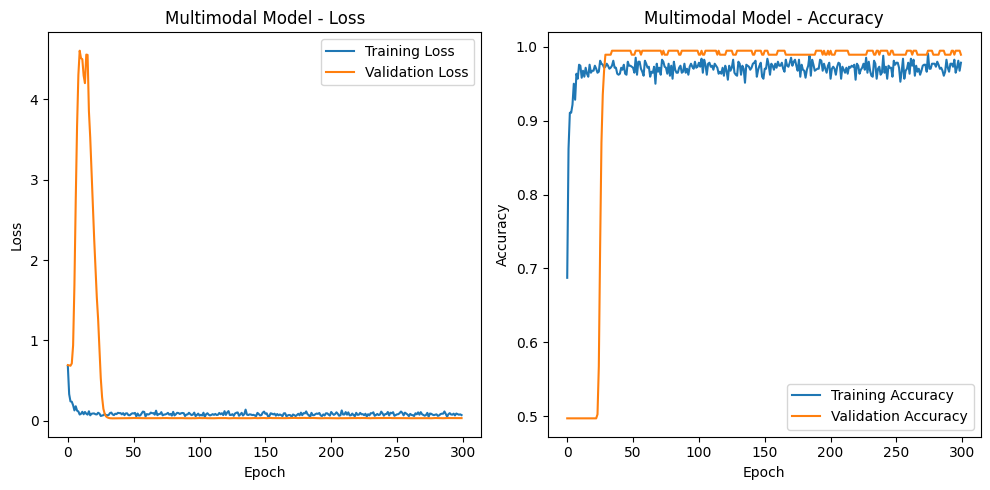

In [30]:
# Plot training history for multimodal model
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(history_multimodal.history['loss'], label='Training Loss')
plt.plot(history_multimodal.history['val_loss'], label='Validation Loss')
plt.title('Multimodal Model - Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(history_multimodal.history['accuracy'], label='Training Accuracy')
plt.plot(history_multimodal.history['val_accuracy'], label='Validation Accuracy')
plt.title('Multimodal Model - Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()


plt.tight_layout()
plt.show()

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
MULTIMODAL MODEL EVALUATION RESULTS
Test Accuracy: 0.9784
Test Precision: 0.9793
Test Recall: 0.9784
Test F1-Score: 0.9784

Detailed Classification Report:
              precision    recall  f1-score   support

   Parkinson       0.96      1.00      0.98       116
No Parkinson       1.00      0.96      0.98       116

    accuracy                           0.98       232
   macro avg       0.98      0.98      0.98       232
weighted avg       0.98      0.98      0.98       232



<Figure size 1200x500 with 0 Axes>

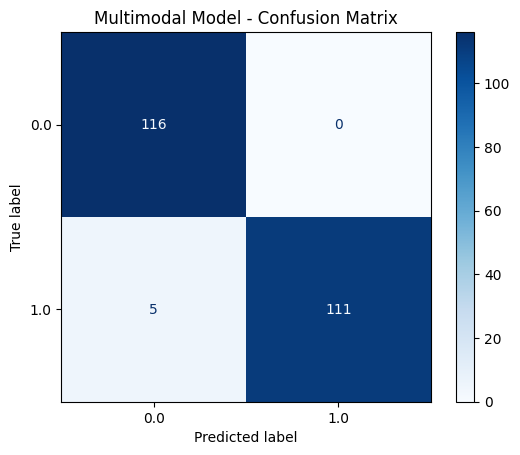

In [35]:
# Evaluate multimodal model
import numpy as np
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, classification_report,
    roc_curve, auc, precision_recall_curve, average_precision_score, confusion_matrix, ConfusionMatrixDisplay,
    RocCurveDisplay, PrecisionRecallDisplay
)

# Prepare test data
test_data = {'audio_input': X_test[:,:50], 'text_input': X_test[:,50:]}

# Predictions
y_pred_probs_multimodal = multimodal_model.predict(test_data)
y_pred_multimodal = np.argmax(y_pred_probs_multimodal, axis=1)

# Calculate metrics
acc_multimodal = accuracy_score(y_test, y_pred_multimodal)
precision_multimodal = precision_score(y_test, y_pred_multimodal, average='weighted')
recall_multimodal = recall_score(y_test, y_pred_multimodal, average='weighted')
f1_multimodal = f1_score(y_test, y_pred_multimodal, average='weighted')

print("="*60)
print("MULTIMODAL MODEL EVALUATION RESULTS")
print("="*60)
print(f"Test Accuracy: {acc_multimodal:.4f}")
print(f"Test Precision: {precision_multimodal:.4f}")
print(f"Test Recall: {recall_multimodal:.4f}")
print(f"Test F1-Score: {f1_multimodal:.4f}")
print("\nDetailed Classification Report:")
print(classification_report(y_test, y_pred_multimodal, target_names=['Parkinson', 'No Parkinson']))

# Confusion Matrix
plt.figure( figsize=(12, 5))

# Confusion Matrix
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_multimodal, cmap='Blues')
plt.title("Multimodal Model - Confusion Matrix")
plt.show()

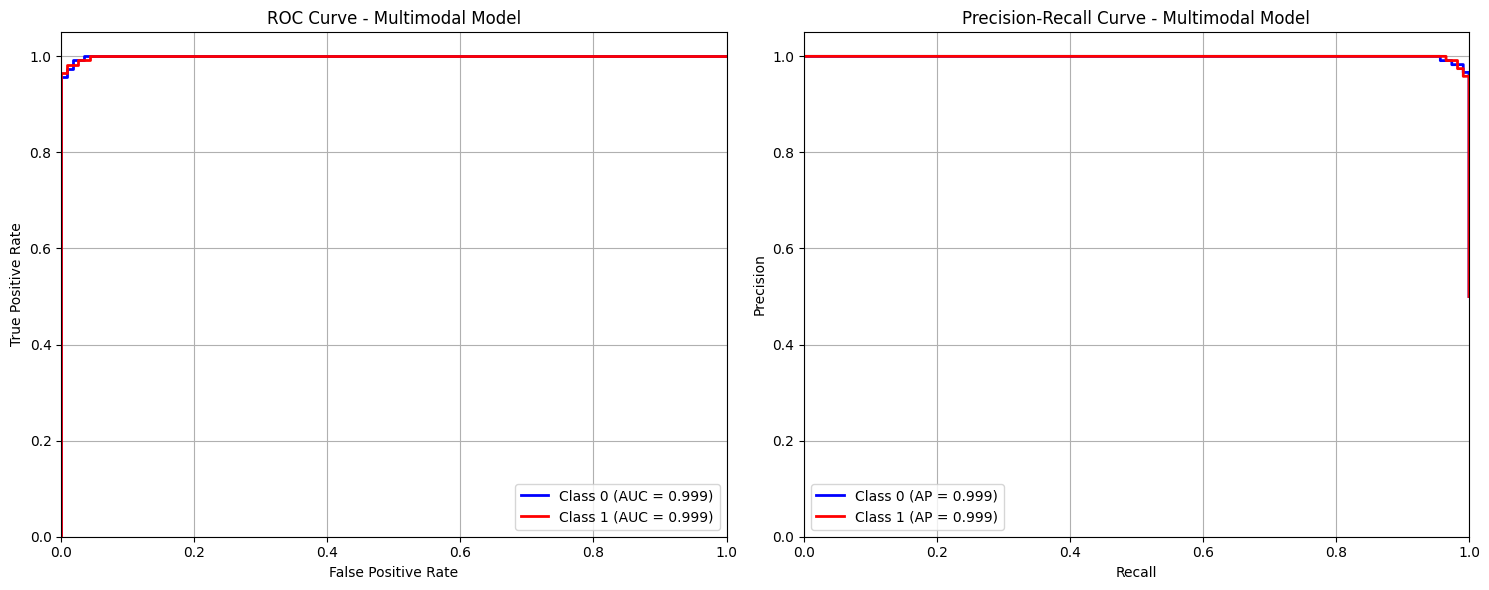


AUC Scores:
Parkinson: ROC-AUC = 0.9993, PR-AUC = 0.9993
No Parkinson: ROC-AUC = 0.9993, PR-AUC = 0.9993


In [38]:
# ROC and Precision-Recall Curves for Multimodal Model
n_classes = len(np.unique(y_test))
y_score_multimodal = y_pred_probs_multimodal

# Calculate ROC curves
fpr_mm, tpr_mm, roc_auc_mm = dict(), dict(), dict()
pr_precision_mm, pr_recall_mm, avg_precision_mm = dict(), dict(), dict()

for i in range(n_classes):
    fpr_mm[i], tpr_mm[i], _ = roc_curve(y_test == i, y_score_multimodal[:, i])
    roc_auc_mm[i] = auc(fpr_mm[i], tpr_mm[i])
    
    pr_precision_mm[i], pr_recall_mm[i], _ = precision_recall_curve(y_test == i, y_score_multimodal[:, i])
    avg_precision_mm[i] = average_precision_score(y_test == i, y_score_multimodal[:, i])

# Plot curves
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# ROC Curves
colors = ['blue', 'red', 'green', 'orange', 'purple', 'brown']
for i, color in enumerate(colors[:n_classes]):
    axes[0].plot(fpr_mm[i], tpr_mm[i], color=color, lw=2,
                 label=f'Class {i} (AUC = {roc_auc_mm[i]:.3f})')


axes[0].set_xlim([0.0, 1.0])
axes[0].set_ylim([0.0, 1.05])
axes[0].set_xlabel('False Positive Rate')
axes[0].set_ylabel('True Positive Rate')
axes[0].set_title('ROC Curve - Multimodal Model')
axes[0].legend(loc="lower right")
axes[0].grid(True)

# Precision-Recall Curves
for i, color in enumerate(colors[:n_classes]):
    axes[1].plot(pr_recall_mm[i], pr_precision_mm[i], color=color, lw=2,
                 label=f'Class {i} (AP = {avg_precision_mm[i]:.3f})')

axes[1].set_xlim([0.0, 1.0])
axes[1].set_ylim([0.0, 1.05])
axes[1].set_xlabel('Recall')
axes[1].set_ylabel('Precision')
axes[1].set_title('Precision-Recall Curve - Multimodal Model')
axes[1].legend(loc="lower left")
axes[1].grid(True)

plt.tight_layout()
plt.show()

# Print AUC scores
print("\nAUC Scores:")
for i in range(n_classes):
    class_name = 'Parkinson' if i == 0 else 'No Parkinson'
    print(f"{class_name}: ROC-AUC = {roc_auc_mm[i]:.4f}, PR-AUC = {avg_precision_mm[i]:.4f}")